# Related Question Analysis
這個檔案我是想要用最 naive 的方法分析 Bert 他找尋相似問題的 performance。
首先我們從我們的 dataset，我們可以知道每個句子被使用者自行標記的 label(catName)。
現在我把 dataset 中每一個句子都當作 query sentence，去問說有哪個句子和她最相近。如果最相近的句子和 query sentence 是屬於同一個  label(catName)，那麼我們就說這個預測是準確的；反之如果是不同的 label(catName)，我們就說預測錯誤。

根據以上的建議判斷方式我們可以計算 top1 以及 top3 的準確率。

In [1]:
import torch
import torch.nn as nn

import os
import re
from tqdm import tqdm, trange
import pickle
import numpy as np
import pandas as pd
from multiprocessing import Pool

import seaborn as sn
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

path = os.path.join("..","data","./newdata_clean.xlsx")
loadpath = "processed_data_bert_expand"
bert_data_path = "bert_expand.pkl"
analysis_output_path = "related_question_analysis"

# If you use GPU to calculate, you only need two minute. However, if not, you need roughtly an hour to calculate.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
print('Using device:', device)

Using device: cuda:0


## Read Data

Read dataset with bert sentence representation

In [2]:
with open(bert_data_path, "rb") as f:
    bert_data = pickle.load(f)
clean_data = bert_data["clean_data"]
reduced_data = bert_data["reduced_data"]
token_data = bert_data["token_data"]
bert_output = bert_data["bert_data"]

print("Type: ", type(bert_output), bert_output.shape)
bert_tensor = torch.from_numpy(bert_output).to(device)
bert_norm = bert_tensor / torch.norm(bert_tensor, dim=1).view(-1, 1)

Type:  <class 'numpy.ndarray'> (100910, 768)


In [3]:
df = pd.read_excel(path).drop_duplicates(subset="question", keep='last')

le = preprocessing.LabelEncoder()
le.fit(df['catName'].unique())
num_classes = len(le.classes_)
class_list = list(le.classes_)

for i, c in enumerate(class_list):
    print("{}: {}".format(i, c))

print("number of classes:",num_classes)
df.loc[:,'catName'] = le.transform(df.loc[:,'catName'])
data = df[['question', 'catName']]

data.set_index('question',inplace=True)
print(data.head())
data = data
data.head()

0: Does the program support certain features?
1: Download/installation issues with Application Manager.
2: Error message pops up when I perform some action.
3: How do I …?
4: How to activate/register my product?
5: How to edit?
6: How to produce file?
7: How to set preferences/settings?
8: How to use certain effects/features?
9: I cannot install/download
10: I forget my password.
11: I have a suggestion
12: I have a suggestion.
13: I have activation problem.
14: I have activation/registration problem.
15: I have already paid, but …
16: I have component activation problem
17: I have install/uninstall/upgrade/patch problems.
18: I have other feedback
19: I have other install/uninstall problems.
20: I have other issue(s)
21: I have other membership question.
22: I have other product feature question.
23: I have other product info/feature question
24: I have other purchasing question.
25: I have other questions.
26: I have other questions/issues.
27: I have other trouble(s).
28: I have pri

,catName
question,
Hello. I wondering if i can reinstall Ultra Power dvd. I have a harddrive reinstalled so that program is lost now. My serial key to the program is UU5EL-7667Q-SEMFM-LQCCU-R8W43-SP9E6. Janne,46
Hello. How can download the $59.95 software purchased about 3/27/2019? And what is the name? Thanks,46
"Hello. I make upgrade from PowerDVD17 Ultra to newest version last year now i need to reinstall. And I dont know how to do it. I download trial PowerDVD18 but cant enter product key. Download link from order mail dont work anymore and I ended without any PowerDVD on pc... What I can do now??? I have all order receipt. Best regards, Bartłomiej Nosal",46
Hello. I´v been using Powerdvd for a long time and recently purschased PD 18 Ultra. After a computercrash i went to my account and tried to find a download. All i can see is the trial wich can´t be activated to my knowledge. What do do? Best regards Mats Jansson,46
"hello..i have needed to reinstall power-dvd and it is the trial version...cannot activate the product,can you please help?",46


`predict_index()` 會根據你為近來句子的 index 找到最相近的句子，並且回傳一個 list，list 的內容是前 `num_related` 相似的句子。

`num_related`: 這個參數決定找前幾相似的句子。

`verbal`: 這個參數決定要不要印出相似的句子。

`range(1, num_related + 1)`: 要注意這這邊排除到跟自己一樣的句子，因為這樣子的 similarity 會是最高的 1，可是並沒有意義。

In [4]:
def predict_index(index, num_related=3, verbal=False):
    if verbal:
        print("Query: {}".format(clean_data[index]))
    
    similarity = torch.matmul(bert_norm, bert_norm[index].view(-1,1))
    rank = torch.argsort(similarity, dim=0, descending=True)
    ret = []
    for i in range(1, num_related + 1):
        ret.append(reduced_data[rank[i]])
        if verbal:
            print("\n" + "=" * 10 + "Similarity: {}".format(similarity[rank[i]][0]) + "=" * 10)
            print(re.sub(r'<[^<]*?/?>', '', reduced_data[rank[i]])) # remove output sentence html 
            #print()
            #print(clean_data[rank[i]])
    return ret

In [5]:
gt_list = []
predict_list = []

for index in trange(len(clean_data)):
    ret = predict_index(index, verbal=False)
    gt = data.loc[reduced_data[index]]['catName']
    #print(gt)
    gt_list.append(gt)
    predict_class_index = list(map(lambda s: data.loc[s]['catName'], ret))
    #print(predict_class_index)
    predict_list.append(predict_class_index)

print("clean_data:", len(clean_data))
print("gt_list:", len(gt_list))
print("predict_list:", len(predict_list))

100%|██████████| 100910/100910 [03:06<00:00, 544.09it/s]

clean_data: 100910
gt_list: 100910
predict_list: 100910


把算好的結果輸出。

In [6]:
analysis_data = {
    "gt": gt_list,
    "predict": predict_list,
}
with open(analysis_output_path, "wb") as f:
    pickle.dump(analysis_data, f)

In [7]:
with open(analysis_output_path, "rb") as f:
    analysis_data = pickle.load(f)
gt_list = analysis_data["gt"]
predict_list = analysis_data["predict"]

predict_list_first = np.array(predict_list)[:,0]
predict_str = list(le.inverse_transform(predict_list_first))
gt_str = list(le.inverse_transform(gt_list))

## Draw Confusion Matrix

In [8]:
def analysis(predicts, gt, labels):
    matrix = confusion_matrix(gt, predicts, labels=labels)
    df = pd.DataFrame(matrix, columns=labels, index=labels)
    #print(df.head())
    figsize = (80, 25)
    plt.figure(figsize=figsize)
    plt.title('Related Question Confusion Matrix', y=1.03, fontsize = 25)
    #cmap = sn.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
    heatmap = sn.heatmap(df, annot=True, annot_kws={"size": 16}) # , cmap=cmap
    plt.ylabel('Ground Truth', fontsize = 20)
    plt.xlabel('Prediction', fontsize = 20)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment="right")
    plt.savefig('ConfusionMatrix_RelatedQuestion.png', bbox_inches = "tight")
    
    
    normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] # normalize
    normalized_matrix = np.nan_to_num(normalized_matrix).round(2)
    df = pd.DataFrame(normalized_matrix, columns=labels, index=labels)
    
    plt.figure(figsize=figsize)
    plt.title('Related Question Normalized Confusion Matrix', y=1.03, fontsize = 25)
    #cmap = sn.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
    heatmap = sn.heatmap(df, annot=True, annot_kws={"size": 16}) # , cmap=cmap
    plt.ylabel('Ground Truth', fontsize = 20)
    plt.xlabel('Prediction', fontsize = 20)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment="right")
    plt.savefig('Normalized_ConfusionMatrix_RelatedQuestion.png', bbox_inches = "tight")

## Calculate Accuracy

Accuracy@1: 0.3448122088990189
Accuracy@3: 0.5279655138241998


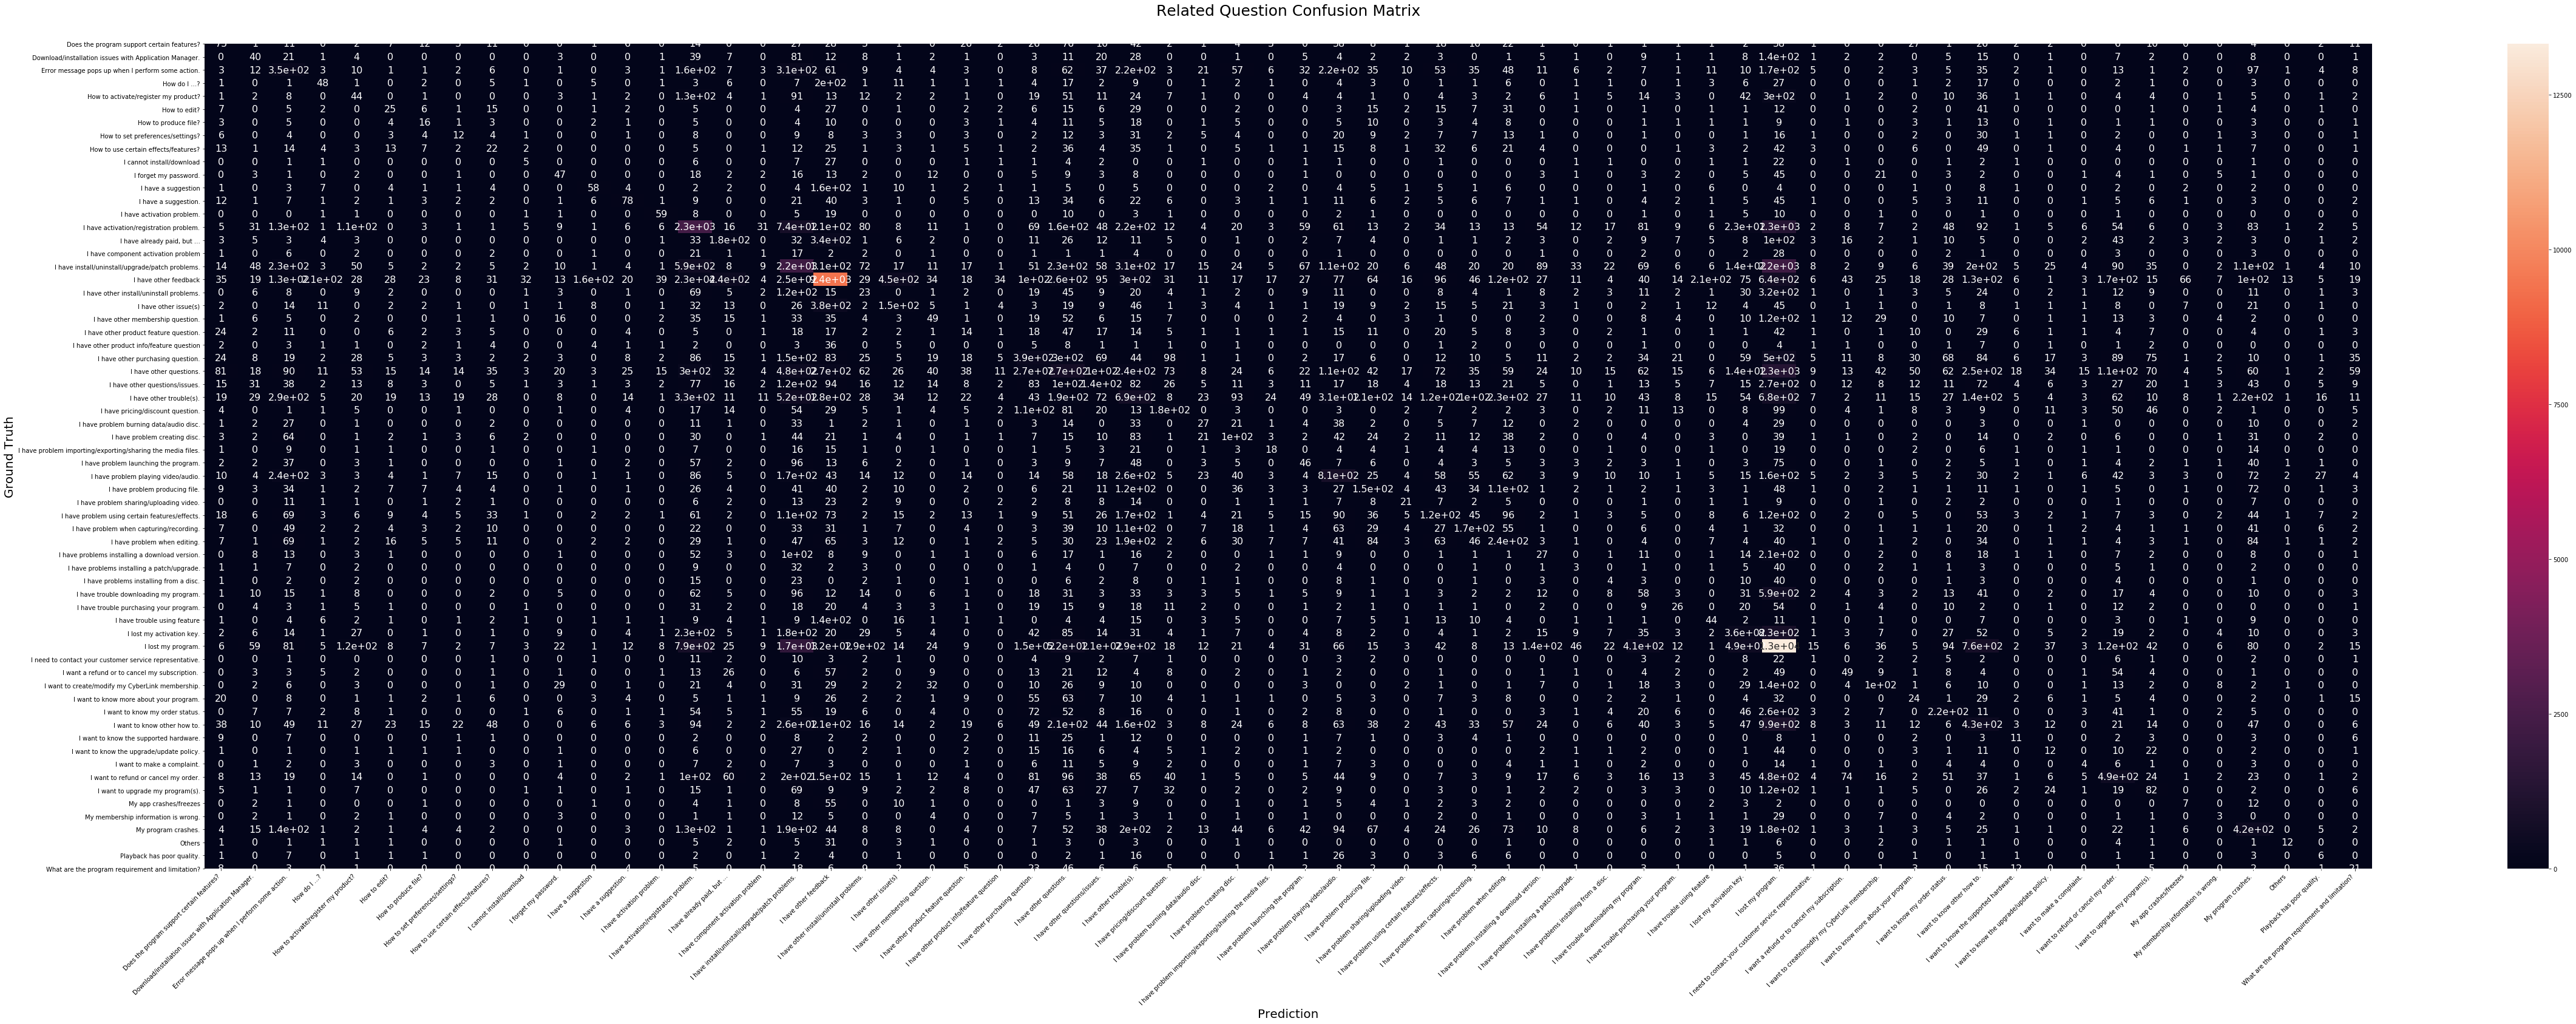

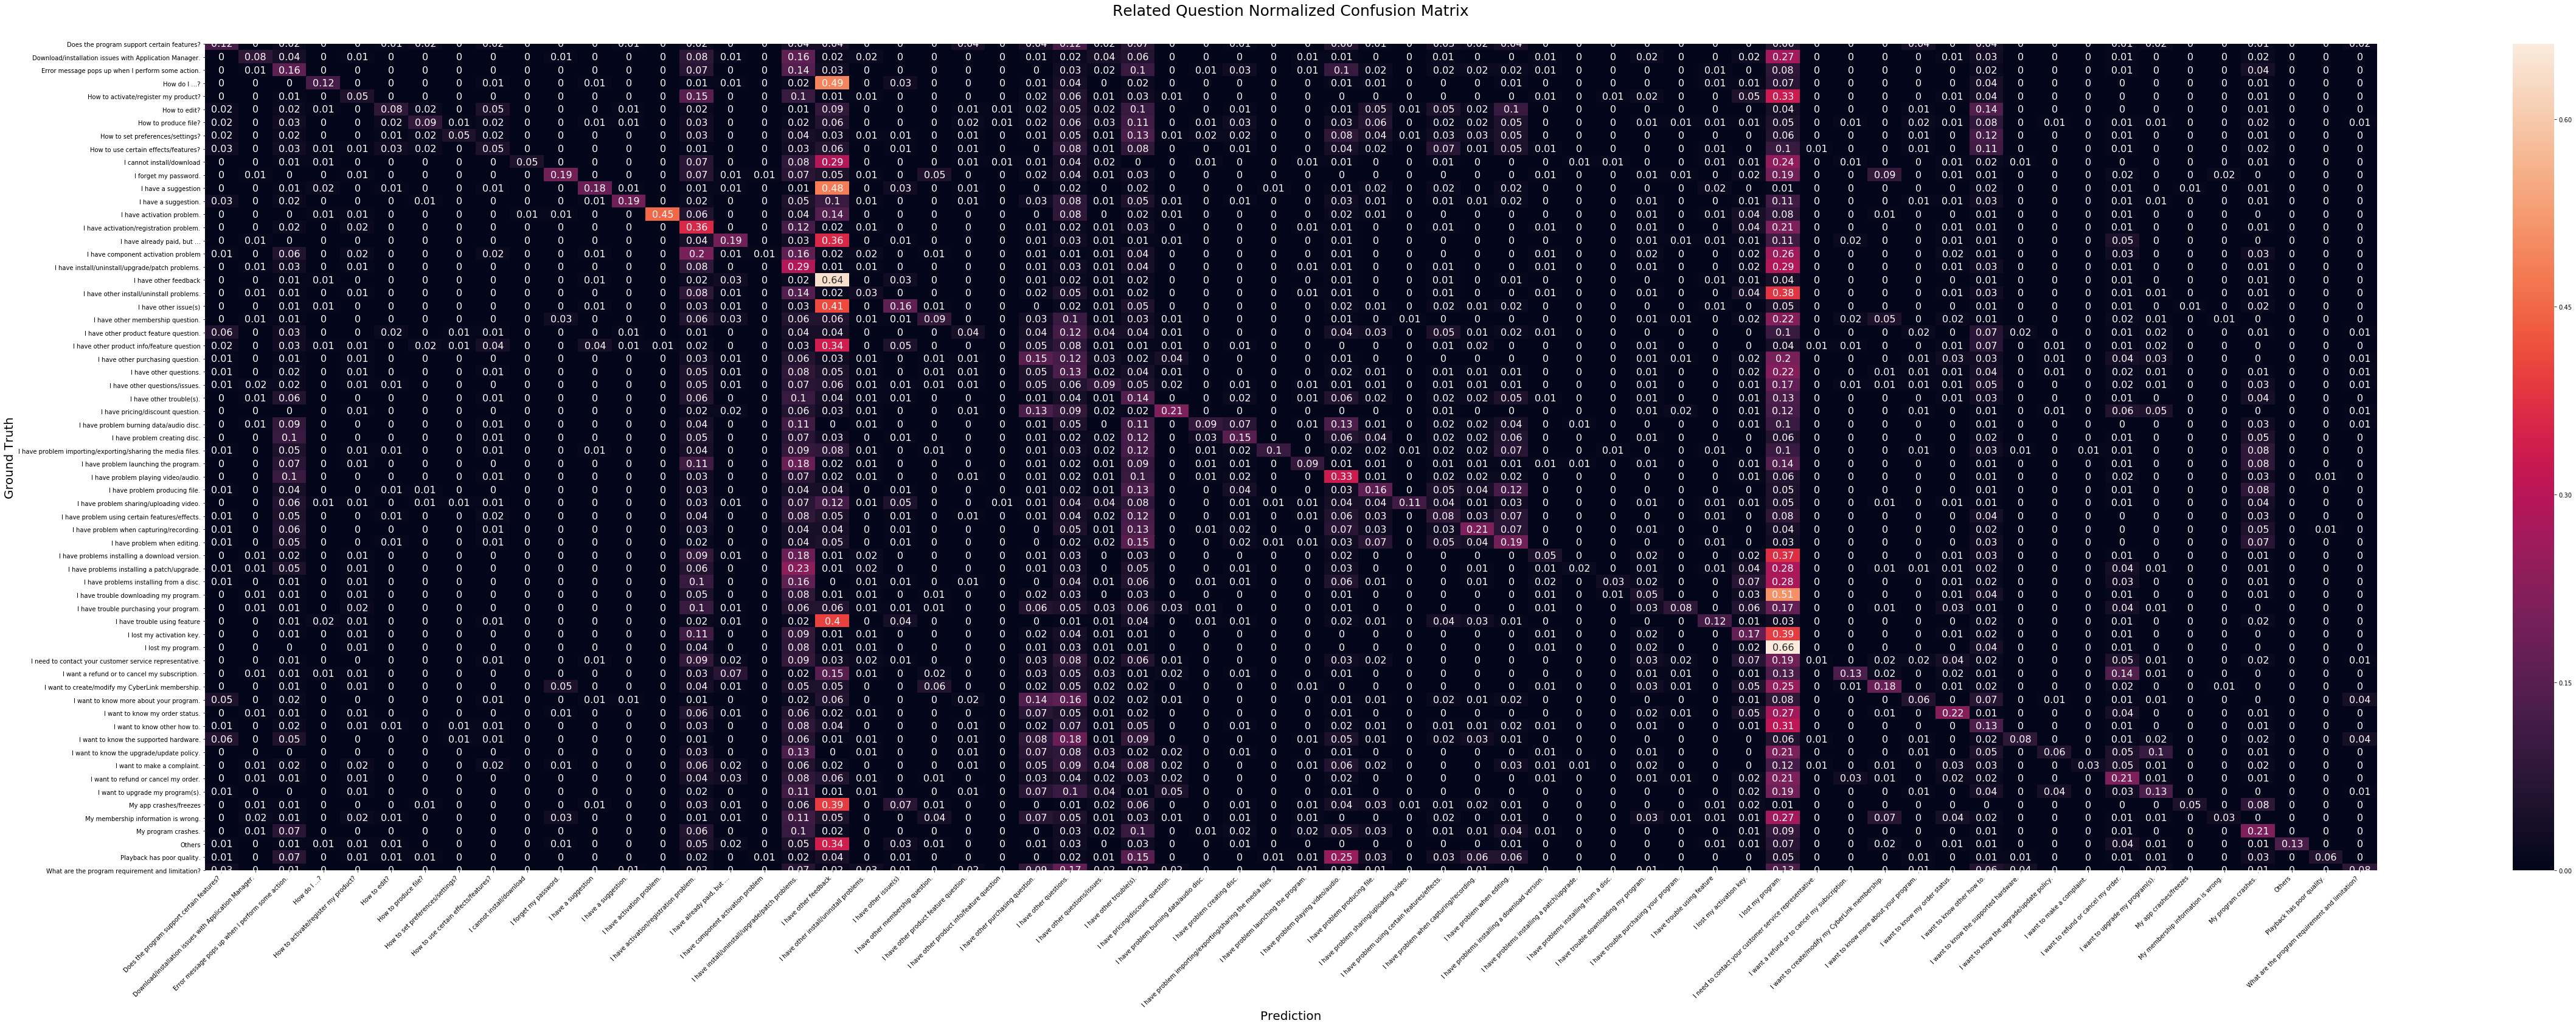

In [9]:
analysis(predict_str, gt_str, labels=class_list)

n = 0
correct1 = 0
correct3 = 0
for i in range(len(gt_list)):
    n += 1
    if gt_list[i] == predict_list[i][0]:
        correct1 += 1
    if gt_list[i] in predict_list[i]:
        correct3 += 1
print("Accuracy@1: {}".format(correct1 / n))
print("Accuracy@3: {}".format(correct3 / n))

## Future Work
其實這個分析只是最初淺的分析，因為如果細看 dataset 所出現的 64 個 label(catName) 的話，就會發現其實很多 label 是一樣的，這也是為什麼 performance 會蠻差的緣故。

另外像是我現在用的句子表示方法（直接把句子每個字的 bert word representation 取平均）其實並沒有考慮到字的先後順序，這些都是還可以再改進的地方。